In [23]:
%matplotlib notebook                    
import matplotlib.pyplot as plt
# Some top options to allow drawing plots

# Two species experiment processing pipeline

**Workflow to process the experiments realized by Vaidotas**

The data is in this [S3 repository](https://console.aws.amazon.com/s3/home?region=us-east-1&bucket=dplab-data&prefix=sc-seq/rna_protect/100kda/)

## SAM files
Vaidotas generated separate SAM files corresponding to human and mice cells. The original log is in the bucket linked above, it is an indrop_v2 run corresponding to Basespace identifier 35611431.

## SeqC

To update your installation, enter the file where it was installed with git clone and run:

    git fetch origin                                       # import changes from the remote repository
    git checkout origin <branch name>                      # master or develop, master is supposedly stable
or
    
    git checkout e0633c083dce1eadc14b8f421232b4780c9d95b5  # the version I used

You must have your Github password or a SSH key as long as Seqc will remain a private repository.

### Annotation
The annotation file in dplab-data/genomes/hg19_mm10 was originally used, but it only included exons
rather than full gene models. FYI the gtf format is used to represent features of a genome ([ref](http://useast.ensembl.org/info/website/upload/gff.html)).

In this case, it is possible to either merge across exons or generate a new annotation. I chose the later, using genomes mm38 and hg38.

I made a small script that uses awk to add a prefix to all the chromosomes (1 -> HUMAN_1), skipping commented lines.

    aws s3 cp s3://dplab-data/genomes/mm38/annotations.gtf mm38/annotations.gtf                 # download
    aws s3 cp s3://dplab-data/genomes/hg38/annotations.gtf hg38/annotations.gtf
    ./prefixGTF.sh -a mm38/annotations.gtf,hg38/annotations.gtf -p MOUSE,HUMAN > mm38_hg38.gtf  # merging
    aws s3 cp mm38_hg38.gtf s3://dplab-data/genomes/mm38_hg38/annotations.gtf                   # uploading
    
You end up with a new merged annotation in dplab-data/genomes/mm38_hg38/annotations.gtf

### SeqC command lines

I am starting from the sam file step, where we generate read arrays and do the various filtering steps. The files are in a folder called BamFiles.

    ./process_experiment.py in_drop_v2 -i s3://dplab-data/genomes/mm38_hg38 -o s3://dplab-data/sc-seq/rna_protect/100kda/Mouse_out_mm38_hg38Index -s s3://dplab-data/sc-seq/rna_protect/100kda/BamFiles/Aligned.out.sam_MOUSE --email-status ccc2177@columbia.edu --barcode-files s3://dplab-data/barcodes/in_drop_v2/flat/ --instance-type r3
    
    ./process_experiment.py in_drop_v2 -i s3://dplab-data/genomes/mm38_hg38 -o s3://dplab-data/sc-seq/rna_protect/100kda/Mouse_out_mm38_hg38Index -s s3://dplab-data/sc-seq/rna_protect/100kda/BamFiles/Aligned.out.sam_MOUSE --email-status ccc2177@columbia.edu --barcode-files s3://dplab-data/barcodes/in_drop_v2/flat/ --instance-type r3
    
* -i specifies where is the new annotation we generated
* -o is the output
* -s is the sam file
* the rest is pretty clear, just change the email
    
If you want to download the result to a folder called `mouse`, you can use:

    mkdir mouse                                                                           # make folder
    aws s3 sync s3://dplab-data/sc-seq/rna_protect/100kda/Mouse_out_mm38_hg38Index mouse  # grab output
    cd mouse && gunzip Mouse_out_mm38_hg38Index_counts.csv.gz                             # uncompress
    
Do the same with the human SAM file. For some reason I don't get a run summary in seqc.log

## Dealing with the SeqC output

You now have in your local folders (one for human, one for mouse): 

- a *.h5* file: encodes all the reads in the HDF5 format
- a file ending in *_reads_and_count_matrices.p* : a sparse matrix with basic error correction, can be loaded straight into an experience object with a Python call to `seqc.core.Experiment.from_count_matrices`
- a CSV file ending in *_counts.csv*: a CSV file that represents the final output of seqc after all the various filtering steps.

Just edit the `os.chdir` command below (ie change directory) to the folder where you downloaded the run results. Here I assume that there are a `mouse` and a `human` subfolders.

In [24]:
import os

os.chdir("/home/cyril/Documents/Dana_Rotation/No_cells")        # Change to your folder
print("*","\n* ".join(os.listdir()))                            # This line displays its contents

* Aligned.out.bam
* Aligned.out.sam
* Aligned.out.sam_hs37d
* Aligned.out.sam_HUMAN
* Aligned.out.sam_MOUSE
* annotations
* ashley.m
* error.txt
* human
* human_30kda
* index
* mouse
* plot_two_species.py
* Primers used in inDrop protocol (version 1).xls
* processing.html
* processing.pdf
* seqc (1).log
* seqc.log
* split_samfile.py
* __pycache__


We can start by taking a look at the CSV files. They describe the result as a dense dataframe after multiple filtering and statistical tests.

In [25]:
mouse_counts= pandas.read_csv("./mouse/Mouse_out_mm38_hg38Index_counts.csv",index_col=0)
human_counts= pandas.read_csv("./human/Human_out_mm38_hg38Index_counts.csv",index_col=0)

mouse_counts.iloc[:5,0:10]     # A way to get a small sample of the file

,COX5A,GPR107,TRIM25,TPD52L1,CDH1,CDH4,COMT,RTCA,MCTS1,NDUFA9
121347519728948,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
121896201836443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121938124422556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121938128094958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122430686969067,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Note that 'NaN' means not a number, which we will change to zeros later on. We can use the .shape command to get the dimensions of the dataframes we are dealing with.

In [26]:
print("Mouse cells x genes:", mouse_counts.shape)
print("Human cells x genes:",human_counts.shape)

Mouse cells x genes: (143, 3158)
Human cells x genes: (1, 25)


In [27]:
human_counts

,SUGP2,MYDGF,GM24737-CDIP1,RP24-220F23.1-POLR2E,URGCP,MYL12B,UQCR11,APOL2,RPS6,TBC1D7,...,MT-ATP6,MT-RNR2,MT-RNR1,CFAP45,MYL5,ANXA2P2,RP11-767C1.1,RPL6P27,CARD8-AS1,CTC-1337H24.3
232319943104347,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,...,1.0,3.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0


At this point, we only have a very small number of cells that have been retained. I will look into that later.

Right now, we can instead take a look at the sparse count matrices obtained from the read array. They are meant to be loaded into a `seqc::core::Experiment` Python object.

In [28]:
import pandas               # the framework we will use for the analysis
import seqc

# Experiment objects
human_exp=seqc.core.Experiment.from_count_matrices("./human/Human_out_mm38_hg38Index_read_and_count_matrices.p") 
mouse_exp=seqc.core.Experiment.from_count_matrices("./mouse/Mouse_out_mm38_hg38Index_read_and_count_matrices.p")

print("Human results:\n"+str(human_exp))
print()
print("Mouse results:\n"+str(mouse_exp))

Human results:
Experiment: 11544 cells x 2847 genes
sparse=True
cluster_assignments=None
diffusion_eigenvalues=None
diffusion_eigenvectors=None
diffusion_map_correlations=None
metadata=True
molecules=True
normalized=False
pca=None
tsne=None

Mouse results:
Experiment: 14483 cells x 10496 genes
sparse=True
cluster_assignments=None
diffusion_eigenvalues=None
diffusion_eigenvectors=None
diffusion_map_correlations=None
metadata=True
molecules=True
normalized=False
pca=None
tsne=None


We definitely lost cells during the later filtering steps.

We take the `molecules` attribute, sum over the rows (genes) to get a total molecule count per cell. This is also matches the total number of transcripts available in a given cell.

In [29]:
# Convert the Experiment into a pandas.DataFrame: same index, but do an horizontal sum 
human_sum=pandas.DataFrame(human_exp.molecules.sum(1),index=human_exp.molecules.index,columns=['human'])  
mouse_sum=pandas.DataFrame(mouse_exp.molecules.sum(1),index=mouse_exp.molecules.index,columns=['mouse'])
# We merge the DataFrames into a single one. 
# We use a 'outer'join, ie we take ALL the rows of each these dataframes
# If a cell barcode is seen in only one species dataframes, we mark the other as missing (NaN).
merging_mol_data=pandas.DataFrame.merge(human_sum, mouse_sum, how='outer',  
      left_index=True, right_index=True, sort=True,
      suffixes=('_human', '_mouse'), copy=True, indicator=False)
merging_mol_data[:8]

,human,mouse
121270371801515,16.0,35.0
121270371806515,2.0,2.0
121270371830629,12.0,17.0
121270371835179,1.0,1.0
121270372002654,14.0,13.0
121270372055862,20.0,32.0
121270372060062,1.0,NaN
121270372060509,NaN,1.0


In [30]:
merged_and_cleaned=merging_mol_data.fillna(0) # we replace the NaN values with 0s
merged_and_cleaned[:8]

,human,mouse
121270371801515,16.0,35.0
121270371806515,2.0,2.0
121270371830629,12.0,17.0
121270371835179,1.0,1.0
121270372002654,14.0,13.0
121270372055862,20.0,32.0
121270372060062,1.0,0.0
121270372060509,0.0,1.0


In [31]:
# We can ask some statistics about the number of transcripts per cell
merged_and_cleaned.describe()

,human,mouse
count,16989.000000,16989.000000
mean,5.700394,12.559009
std,6.823798,14.708774
min,0.000000,0.000000
25%,0.000000,1.000000
50%,2.000000,5.000000
75%,10.000000,22.000000
max,49.000000,132.000000


We can then display a scatter plot.

<IPython.core.display.Javascript object>


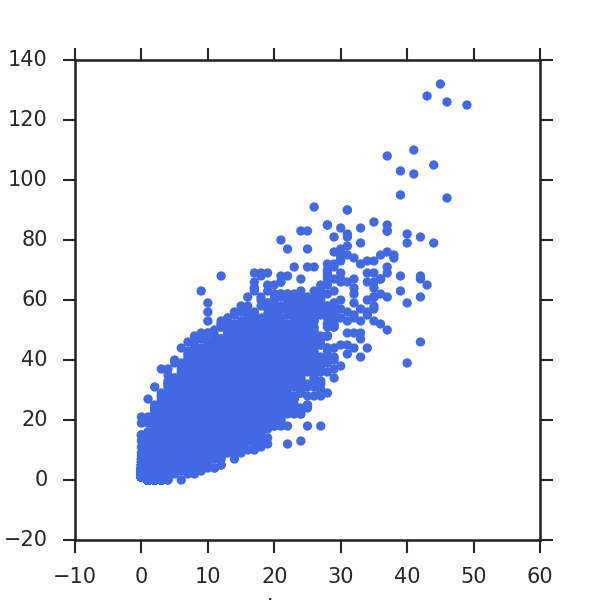

In [32]:
merged_and_cleaned.plot.scatter(x="human",y="mouse")

We can also do the same thing with our reads, which should look similar but be more scattered.

In [33]:
rhuman_sum=pandas.DataFrame(human_exp.reads.sum(1),index=human_exp.reads.index,columns=['human'])  # convert
rmouse_sum=pandas.DataFrame(mouse_exp.reads.sum(1),index=mouse_exp.reads.index,columns=['mouse'])

rmerging_mol_data=pandas.DataFrame.merge(rhuman_sum, rmouse_sum, how='outer',     # merge
      left_index=True, right_index=True, sort=True,
      suffixes=('_human', '_mouse'), copy=True, indicator=False)

rmerged_and_cleaned=rmerging_mol_data.fillna(0)                                  # fill NA with 0s
rmerged_and_cleaned[:8]

,human,mouse
121270371801515,79.0,152.0
121270371806515,7.0,7.0
121270371830629,50.0,105.0
121270371835179,4.0,1.0
121270372002654,80.0,99.0
121270372055862,134.0,208.0
121270372060062,1.0,0.0
121270372060509,0.0,1.0


In [34]:
rmerged_and_cleaned.describe()

,human,mouse
count,16989.000000,16989.000000
mean,29.752369,70.575255
std,39.590303,87.682641
min,0.000000,0.000000
25%,0.000000,1.000000
50%,10.000000,28.000000
75%,50.000000,123.000000
max,292.000000,773.000000


<IPython.core.display.Javascript object>


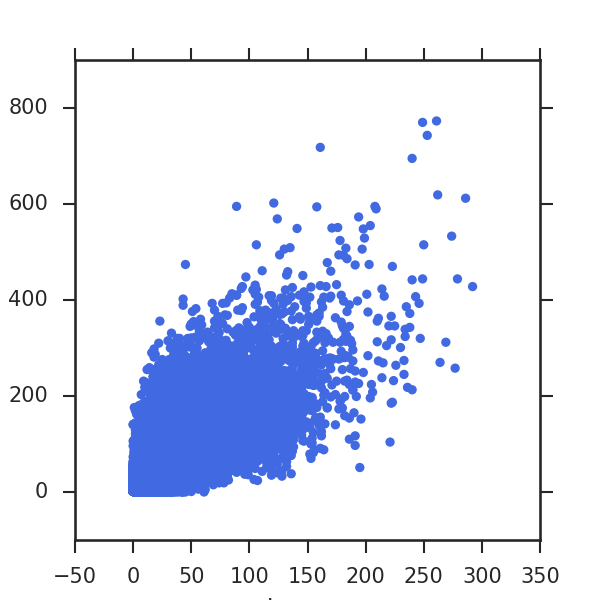

In [35]:
rmerged_and_cleaned.plot.scatter(x="human",y="mouse")